# **1. Import libraries and MNIST dataset**

In [13]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

# **2. Define Convolutional Autoencoder**

In [14]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# **3. Initialize Loss function and the optimizer**

In [15]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

# **4. Train and evaluate model**

In [16]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [17]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [18]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253075
	 partial train loss (single batch): 0.245974
	 partial train loss (single batch): 0.240404
	 partial train loss (single batch): 0.235971
	 partial train loss (single batch): 0.232010
	 partial train loss (single batch): 0.228118
	 partial train loss (single batch): 0.225342
	 partial train loss (single batch): 0.222383
	 partial train loss (single batch): 0.220323
	 partial train loss (single batch): 0.217922
	 partial train loss (single batch): 0.215396
	 partial train loss (single batch): 0.213903
	 partial train loss (single batch): 0.211185
	 partial train loss (single batch): 0.209166
	 partial train loss (single batch): 0.206831
	 partial train loss (single batch): 0.205134
	 partial train loss (single batch): 0.203681
	 partial train loss (single batch): 0.201061
	 partial train loss (single batch): 0.199057
	 partial train loss (single batch): 0.197480
	 partial train loss (single batch): 0.196405
	 partial train loss (single batch

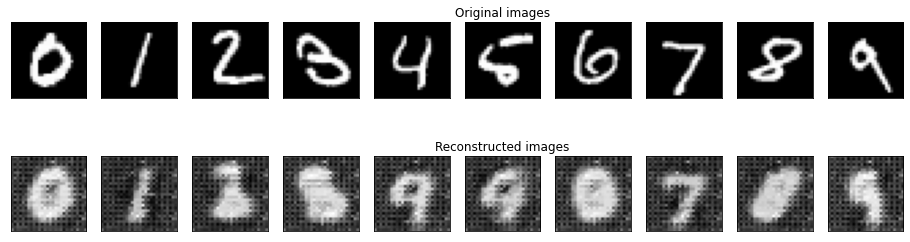

	 partial train loss (single batch): 0.067738
	 partial train loss (single batch): 0.066007
	 partial train loss (single batch): 0.065827
	 partial train loss (single batch): 0.067428
	 partial train loss (single batch): 0.064714
	 partial train loss (single batch): 0.065663
	 partial train loss (single batch): 0.064597
	 partial train loss (single batch): 0.064966
	 partial train loss (single batch): 0.065176
	 partial train loss (single batch): 0.065089
	 partial train loss (single batch): 0.064365
	 partial train loss (single batch): 0.064671
	 partial train loss (single batch): 0.063539
	 partial train loss (single batch): 0.063440
	 partial train loss (single batch): 0.063405
	 partial train loss (single batch): 0.062735
	 partial train loss (single batch): 0.061946
	 partial train loss (single batch): 0.063646
	 partial train loss (single batch): 0.063276
	 partial train loss (single batch): 0.062214
	 partial train loss (single batch): 0.062255
	 partial train loss (single batch

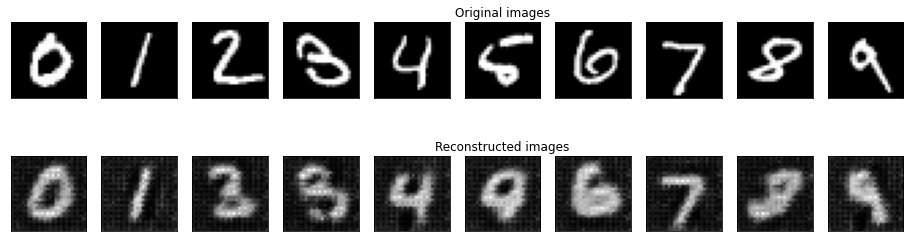

	 partial train loss (single batch): 0.047072
	 partial train loss (single batch): 0.045577
	 partial train loss (single batch): 0.046392
	 partial train loss (single batch): 0.047602
	 partial train loss (single batch): 0.045104
	 partial train loss (single batch): 0.046330
	 partial train loss (single batch): 0.045062
	 partial train loss (single batch): 0.045603
	 partial train loss (single batch): 0.045689
	 partial train loss (single batch): 0.046400
	 partial train loss (single batch): 0.045910
	 partial train loss (single batch): 0.046049
	 partial train loss (single batch): 0.044628
	 partial train loss (single batch): 0.045370
	 partial train loss (single batch): 0.044846
	 partial train loss (single batch): 0.045017
	 partial train loss (single batch): 0.043750
	 partial train loss (single batch): 0.046108
	 partial train loss (single batch): 0.045889
	 partial train loss (single batch): 0.044663
	 partial train loss (single batch): 0.044388
	 partial train loss (single batch

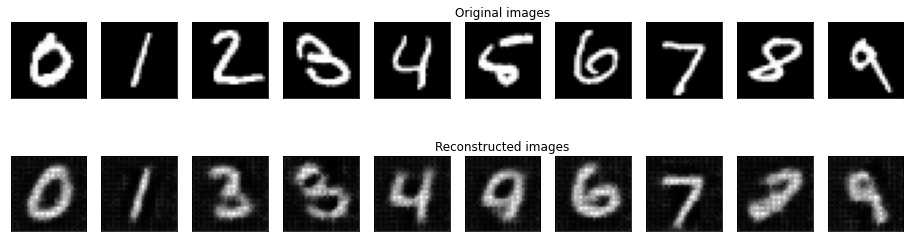

	 partial train loss (single batch): 0.037282
	 partial train loss (single batch): 0.035536
	 partial train loss (single batch): 0.037479
	 partial train loss (single batch): 0.038307
	 partial train loss (single batch): 0.035398
	 partial train loss (single batch): 0.037180
	 partial train loss (single batch): 0.035512
	 partial train loss (single batch): 0.036219
	 partial train loss (single batch): 0.035981
	 partial train loss (single batch): 0.037288
	 partial train loss (single batch): 0.037106
	 partial train loss (single batch): 0.037001
	 partial train loss (single batch): 0.035310
	 partial train loss (single batch): 0.036188
	 partial train loss (single batch): 0.035973
	 partial train loss (single batch): 0.036273
	 partial train loss (single batch): 0.035036
	 partial train loss (single batch): 0.037196
	 partial train loss (single batch): 0.036808
	 partial train loss (single batch): 0.035684
	 partial train loss (single batch): 0.034945
	 partial train loss (single batch

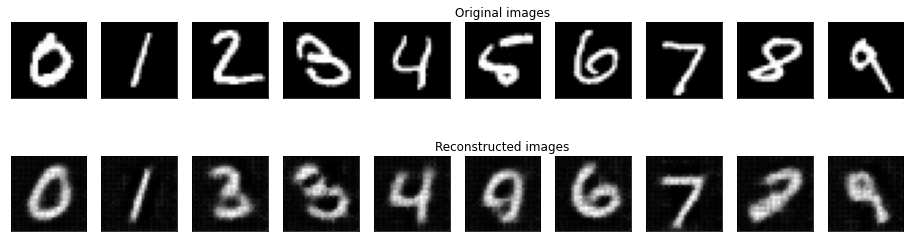

	 partial train loss (single batch): 0.033344
	 partial train loss (single batch): 0.031344
	 partial train loss (single batch): 0.033743
	 partial train loss (single batch): 0.034611
	 partial train loss (single batch): 0.031414
	 partial train loss (single batch): 0.033603
	 partial train loss (single batch): 0.031499
	 partial train loss (single batch): 0.032533
	 partial train loss (single batch): 0.032101
	 partial train loss (single batch): 0.033524
	 partial train loss (single batch): 0.033589
	 partial train loss (single batch): 0.033341
	 partial train loss (single batch): 0.031593
	 partial train loss (single batch): 0.032392
	 partial train loss (single batch): 0.032449
	 partial train loss (single batch): 0.032602
	 partial train loss (single batch): 0.031646
	 partial train loss (single batch): 0.033608
	 partial train loss (single batch): 0.032823
	 partial train loss (single batch): 0.032101
	 partial train loss (single batch): 0.031305
	 partial train loss (single batch

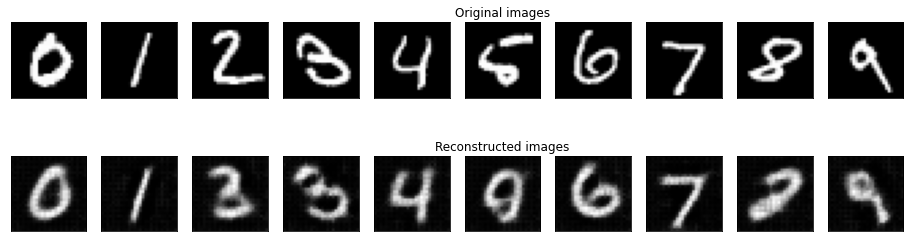

	 partial train loss (single batch): 0.031487
	 partial train loss (single batch): 0.029665
	 partial train loss (single batch): 0.031907
	 partial train loss (single batch): 0.032906
	 partial train loss (single batch): 0.029689
	 partial train loss (single batch): 0.032052
	 partial train loss (single batch): 0.029668
	 partial train loss (single batch): 0.030748
	 partial train loss (single batch): 0.030407
	 partial train loss (single batch): 0.031729
	 partial train loss (single batch): 0.031986
	 partial train loss (single batch): 0.031697
	 partial train loss (single batch): 0.030084
	 partial train loss (single batch): 0.030554
	 partial train loss (single batch): 0.030870
	 partial train loss (single batch): 0.031005
	 partial train loss (single batch): 0.030003
	 partial train loss (single batch): 0.031904
	 partial train loss (single batch): 0.031338
	 partial train loss (single batch): 0.030489
	 partial train loss (single batch): 0.029617
	 partial train loss (single batch

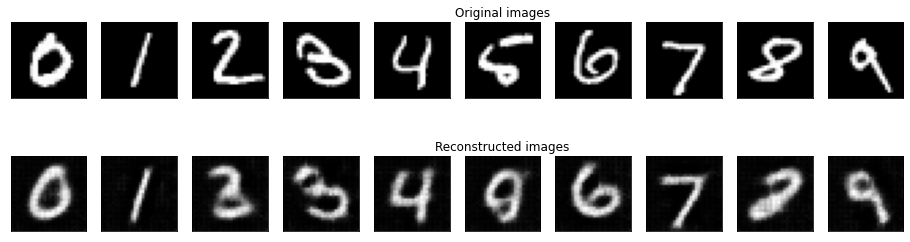

	 partial train loss (single batch): 0.030512
	 partial train loss (single batch): 0.028669
	 partial train loss (single batch): 0.030911
	 partial train loss (single batch): 0.031843
	 partial train loss (single batch): 0.028633
	 partial train loss (single batch): 0.031091
	 partial train loss (single batch): 0.028726
	 partial train loss (single batch): 0.029766
	 partial train loss (single batch): 0.029369
	 partial train loss (single batch): 0.030677
	 partial train loss (single batch): 0.031004
	 partial train loss (single batch): 0.030619
	 partial train loss (single batch): 0.029159
	 partial train loss (single batch): 0.029517
	 partial train loss (single batch): 0.029904
	 partial train loss (single batch): 0.029979
	 partial train loss (single batch): 0.029079
	 partial train loss (single batch): 0.030870
	 partial train loss (single batch): 0.030385
	 partial train loss (single batch): 0.029420
	 partial train loss (single batch): 0.028519
	 partial train loss (single batch

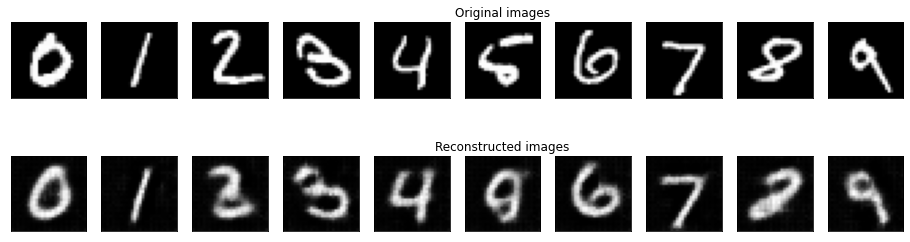

	 partial train loss (single batch): 0.029794
	 partial train loss (single batch): 0.027960
	 partial train loss (single batch): 0.030255
	 partial train loss (single batch): 0.031180
	 partial train loss (single batch): 0.028004
	 partial train loss (single batch): 0.030509
	 partial train loss (single batch): 0.028016
	 partial train loss (single batch): 0.029173
	 partial train loss (single batch): 0.028574
	 partial train loss (single batch): 0.029958
	 partial train loss (single batch): 0.030323
	 partial train loss (single batch): 0.029900
	 partial train loss (single batch): 0.028477
	 partial train loss (single batch): 0.028857
	 partial train loss (single batch): 0.029319
	 partial train loss (single batch): 0.029439
	 partial train loss (single batch): 0.028505
	 partial train loss (single batch): 0.030214
	 partial train loss (single batch): 0.029730
	 partial train loss (single batch): 0.028733
	 partial train loss (single batch): 0.027859
	 partial train loss (single batch

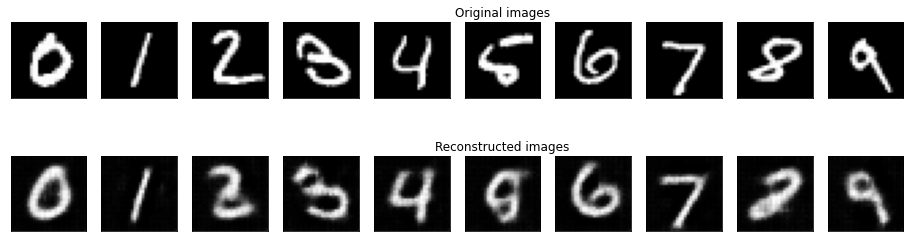

	 partial train loss (single batch): 0.029402
	 partial train loss (single batch): 0.027529
	 partial train loss (single batch): 0.029689
	 partial train loss (single batch): 0.030754
	 partial train loss (single batch): 0.027503
	 partial train loss (single batch): 0.030102
	 partial train loss (single batch): 0.027601
	 partial train loss (single batch): 0.028725
	 partial train loss (single batch): 0.028038
	 partial train loss (single batch): 0.029515
	 partial train loss (single batch): 0.029779
	 partial train loss (single batch): 0.029404
	 partial train loss (single batch): 0.028170
	 partial train loss (single batch): 0.028253
	 partial train loss (single batch): 0.028960
	 partial train loss (single batch): 0.029104
	 partial train loss (single batch): 0.027978
	 partial train loss (single batch): 0.029647
	 partial train loss (single batch): 0.029358
	 partial train loss (single batch): 0.028166
	 partial train loss (single batch): 0.027138
	 partial train loss (single batch

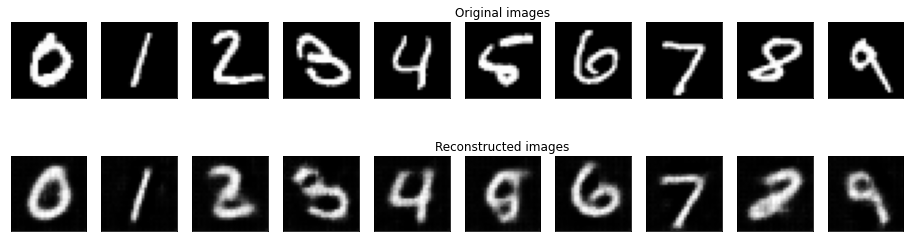

	 partial train loss (single batch): 0.029007
	 partial train loss (single batch): 0.027229
	 partial train loss (single batch): 0.029127
	 partial train loss (single batch): 0.030482
	 partial train loss (single batch): 0.027121
	 partial train loss (single batch): 0.029751
	 partial train loss (single batch): 0.027245
	 partial train loss (single batch): 0.028289
	 partial train loss (single batch): 0.027555
	 partial train loss (single batch): 0.029083
	 partial train loss (single batch): 0.029314
	 partial train loss (single batch): 0.028842
	 partial train loss (single batch): 0.027719
	 partial train loss (single batch): 0.027916
	 partial train loss (single batch): 0.028505
	 partial train loss (single batch): 0.028812
	 partial train loss (single batch): 0.027605
	 partial train loss (single batch): 0.029144
	 partial train loss (single batch): 0.028977
	 partial train loss (single batch): 0.027727
	 partial train loss (single batch): 0.026724
	 partial train loss (single batch

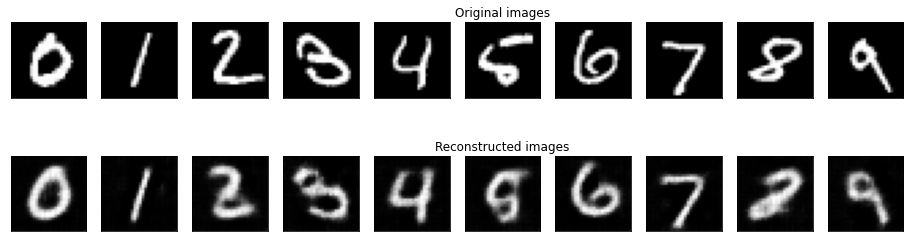

	 partial train loss (single batch): 0.028612
	 partial train loss (single batch): 0.026992
	 partial train loss (single batch): 0.028679
	 partial train loss (single batch): 0.030007
	 partial train loss (single batch): 0.026842
	 partial train loss (single batch): 0.029402
	 partial train loss (single batch): 0.026850
	 partial train loss (single batch): 0.028066
	 partial train loss (single batch): 0.027329
	 partial train loss (single batch): 0.028800
	 partial train loss (single batch): 0.028928
	 partial train loss (single batch): 0.028443
	 partial train loss (single batch): 0.027417
	 partial train loss (single batch): 0.027695
	 partial train loss (single batch): 0.028247
	 partial train loss (single batch): 0.028422
	 partial train loss (single batch): 0.027341
	 partial train loss (single batch): 0.028870
	 partial train loss (single batch): 0.028614
	 partial train loss (single batch): 0.027411
	 partial train loss (single batch): 0.026291
	 partial train loss (single batch

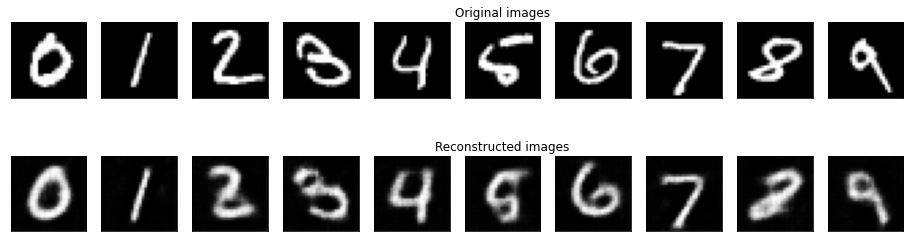

	 partial train loss (single batch): 0.028392
	 partial train loss (single batch): 0.026763
	 partial train loss (single batch): 0.028464
	 partial train loss (single batch): 0.029641
	 partial train loss (single batch): 0.026468
	 partial train loss (single batch): 0.029180
	 partial train loss (single batch): 0.026614
	 partial train loss (single batch): 0.027720
	 partial train loss (single batch): 0.027007
	 partial train loss (single batch): 0.028447
	 partial train loss (single batch): 0.028648
	 partial train loss (single batch): 0.028032
	 partial train loss (single batch): 0.027075
	 partial train loss (single batch): 0.027324
	 partial train loss (single batch): 0.027971
	 partial train loss (single batch): 0.028122
	 partial train loss (single batch): 0.027065
	 partial train loss (single batch): 0.028479
	 partial train loss (single batch): 0.028273
	 partial train loss (single batch): 0.027067
	 partial train loss (single batch): 0.025954
	 partial train loss (single batch

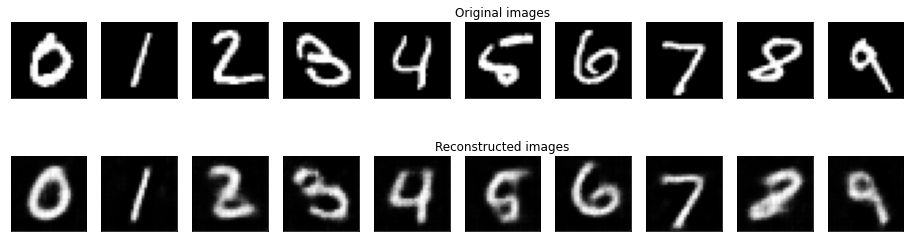

	 partial train loss (single batch): 0.028182
	 partial train loss (single batch): 0.026595
	 partial train loss (single batch): 0.028188
	 partial train loss (single batch): 0.029236
	 partial train loss (single batch): 0.026233
	 partial train loss (single batch): 0.028905
	 partial train loss (single batch): 0.026378
	 partial train loss (single batch): 0.027554
	 partial train loss (single batch): 0.026774
	 partial train loss (single batch): 0.028251
	 partial train loss (single batch): 0.028450
	 partial train loss (single batch): 0.027730
	 partial train loss (single batch): 0.026883
	 partial train loss (single batch): 0.027176
	 partial train loss (single batch): 0.027794
	 partial train loss (single batch): 0.027882
	 partial train loss (single batch): 0.026944
	 partial train loss (single batch): 0.028297
	 partial train loss (single batch): 0.027951
	 partial train loss (single batch): 0.026917
	 partial train loss (single batch): 0.025734
	 partial train loss (single batch

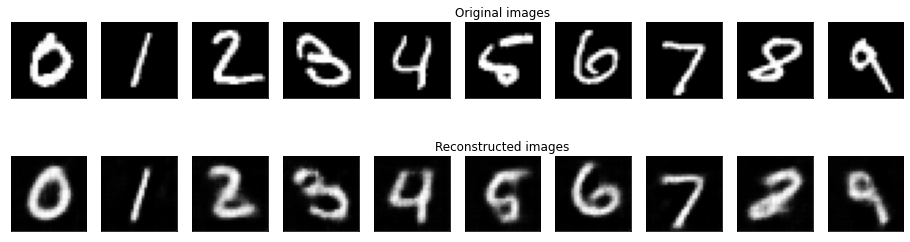

	 partial train loss (single batch): 0.027992
	 partial train loss (single batch): 0.026393
	 partial train loss (single batch): 0.027930
	 partial train loss (single batch): 0.028981
	 partial train loss (single batch): 0.026049
	 partial train loss (single batch): 0.028658
	 partial train loss (single batch): 0.026215
	 partial train loss (single batch): 0.027319
	 partial train loss (single batch): 0.026533
	 partial train loss (single batch): 0.028072
	 partial train loss (single batch): 0.028209
	 partial train loss (single batch): 0.027490
	 partial train loss (single batch): 0.026677
	 partial train loss (single batch): 0.026967
	 partial train loss (single batch): 0.027574
	 partial train loss (single batch): 0.027660
	 partial train loss (single batch): 0.026682
	 partial train loss (single batch): 0.028013
	 partial train loss (single batch): 0.027733
	 partial train loss (single batch): 0.026758
	 partial train loss (single batch): 0.025544
	 partial train loss (single batch

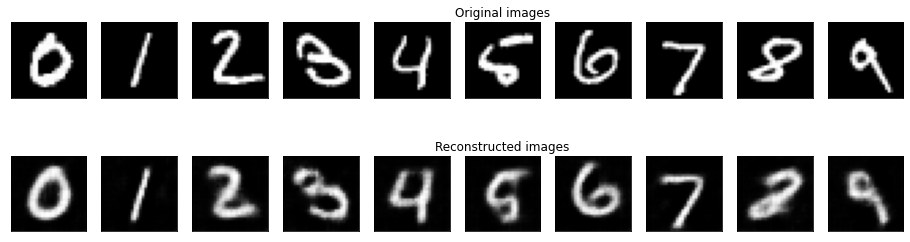

	 partial train loss (single batch): 0.027787
	 partial train loss (single batch): 0.026184
	 partial train loss (single batch): 0.027726
	 partial train loss (single batch): 0.028762
	 partial train loss (single batch): 0.025926
	 partial train loss (single batch): 0.028455
	 partial train loss (single batch): 0.026079
	 partial train loss (single batch): 0.027059
	 partial train loss (single batch): 0.026315
	 partial train loss (single batch): 0.027954
	 partial train loss (single batch): 0.027957
	 partial train loss (single batch): 0.027188
	 partial train loss (single batch): 0.026498
	 partial train loss (single batch): 0.026812
	 partial train loss (single batch): 0.027395
	 partial train loss (single batch): 0.027509
	 partial train loss (single batch): 0.026465
	 partial train loss (single batch): 0.027810
	 partial train loss (single batch): 0.027625
	 partial train loss (single batch): 0.026536
	 partial train loss (single batch): 0.025346
	 partial train loss (single batch

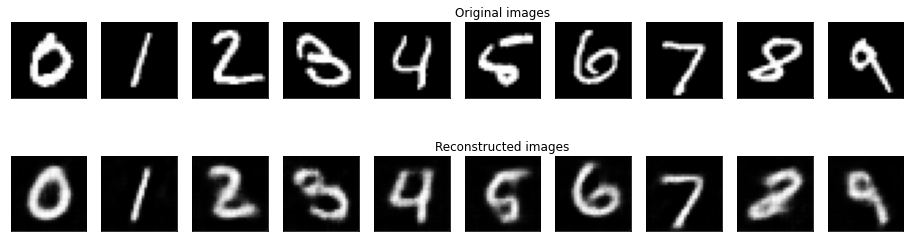

	 partial train loss (single batch): 0.027595
	 partial train loss (single batch): 0.026019
	 partial train loss (single batch): 0.027558
	 partial train loss (single batch): 0.028604
	 partial train loss (single batch): 0.025707
	 partial train loss (single batch): 0.028231
	 partial train loss (single batch): 0.025834
	 partial train loss (single batch): 0.026849
	 partial train loss (single batch): 0.026050
	 partial train loss (single batch): 0.027688
	 partial train loss (single batch): 0.027768
	 partial train loss (single batch): 0.027002
	 partial train loss (single batch): 0.026297
	 partial train loss (single batch): 0.026714
	 partial train loss (single batch): 0.027132
	 partial train loss (single batch): 0.027265
	 partial train loss (single batch): 0.026344
	 partial train loss (single batch): 0.027502
	 partial train loss (single batch): 0.027389
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.025217
	 partial train loss (single batch

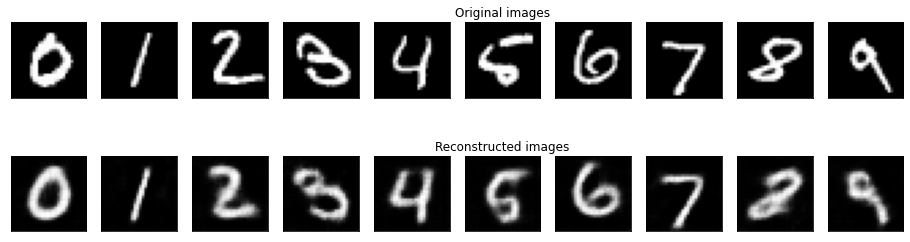

	 partial train loss (single batch): 0.027470
	 partial train loss (single batch): 0.025902
	 partial train loss (single batch): 0.027426
	 partial train loss (single batch): 0.028378
	 partial train loss (single batch): 0.025609
	 partial train loss (single batch): 0.028055
	 partial train loss (single batch): 0.025651
	 partial train loss (single batch): 0.026661
	 partial train loss (single batch): 0.025817
	 partial train loss (single batch): 0.027490
	 partial train loss (single batch): 0.027590
	 partial train loss (single batch): 0.026855
	 partial train loss (single batch): 0.026099
	 partial train loss (single batch): 0.026608
	 partial train loss (single batch): 0.026992
	 partial train loss (single batch): 0.027140
	 partial train loss (single batch): 0.026206
	 partial train loss (single batch): 0.027407
	 partial train loss (single batch): 0.027291
	 partial train loss (single batch): 0.026186
	 partial train loss (single batch): 0.025123
	 partial train loss (single batch

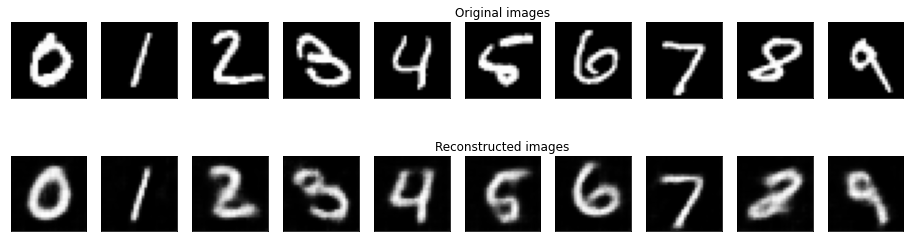

	 partial train loss (single batch): 0.027287
	 partial train loss (single batch): 0.025803
	 partial train loss (single batch): 0.027269
	 partial train loss (single batch): 0.028267
	 partial train loss (single batch): 0.025487
	 partial train loss (single batch): 0.027861
	 partial train loss (single batch): 0.025517
	 partial train loss (single batch): 0.026494
	 partial train loss (single batch): 0.025688
	 partial train loss (single batch): 0.027321
	 partial train loss (single batch): 0.027448
	 partial train loss (single batch): 0.026749
	 partial train loss (single batch): 0.025929
	 partial train loss (single batch): 0.026510
	 partial train loss (single batch): 0.026176
	 partial train loss (single batch): 0.025813
	 partial train loss (single batch): 0.027089
	 partial train loss (single batch): 0.028463
	 partial train loss (single batch): 0.026247
	 partial train loss (single batch): 0.026944
	 partial train loss (single batch): 0.027059
	 partial train loss (single batch

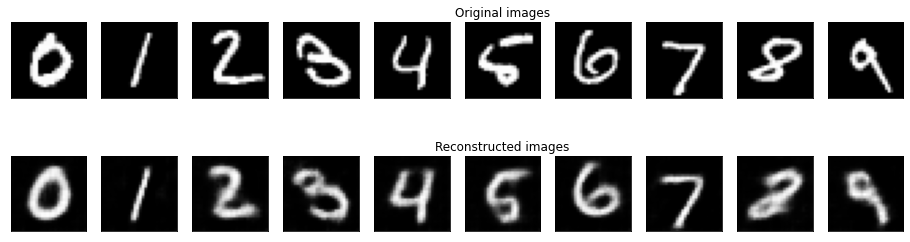

	 partial train loss (single batch): 0.027125
	 partial train loss (single batch): 0.025672
	 partial train loss (single batch): 0.027128
	 partial train loss (single batch): 0.028122
	 partial train loss (single batch): 0.025388
	 partial train loss (single batch): 0.027691
	 partial train loss (single batch): 0.025372
	 partial train loss (single batch): 0.026401
	 partial train loss (single batch): 0.025542
	 partial train loss (single batch): 0.027157
	 partial train loss (single batch): 0.027323
	 partial train loss (single batch): 0.026583
	 partial train loss (single batch): 0.025781
	 partial train loss (single batch): 0.026418
	 partial train loss (single batch): 0.026781
	 partial train loss (single batch): 0.026824
	 partial train loss (single batch): 0.025920
	 partial train loss (single batch): 0.027137
	 partial train loss (single batch): 0.027032
	 partial train loss (single batch): 0.025937
	 partial train loss (single batch): 0.024799
	 partial train loss (single batch

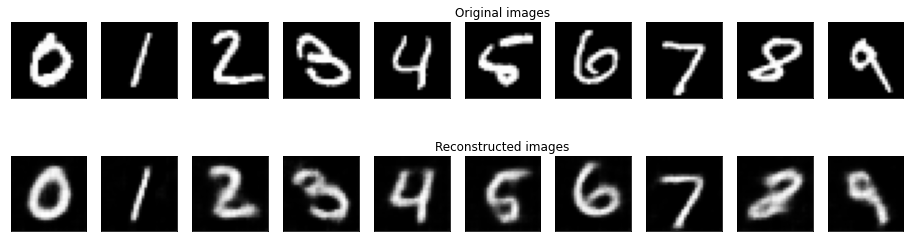

	 partial train loss (single batch): 0.027011
	 partial train loss (single batch): 0.025554
	 partial train loss (single batch): 0.027040
	 partial train loss (single batch): 0.027942
	 partial train loss (single batch): 0.025346
	 partial train loss (single batch): 0.027553
	 partial train loss (single batch): 0.025220
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.025470
	 partial train loss (single batch): 0.027014
	 partial train loss (single batch): 0.027233
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.025616
	 partial train loss (single batch): 0.026393
	 partial train loss (single batch): 0.026685
	 partial train loss (single batch): 0.026751
	 partial train loss (single batch): 0.025852
	 partial train loss (single batch): 0.027027
	 partial train loss (single batch): 0.026917
	 partial train loss (single batch): 0.025862
	 partial train loss (single batch): 0.024661
	 partial train loss (single batch

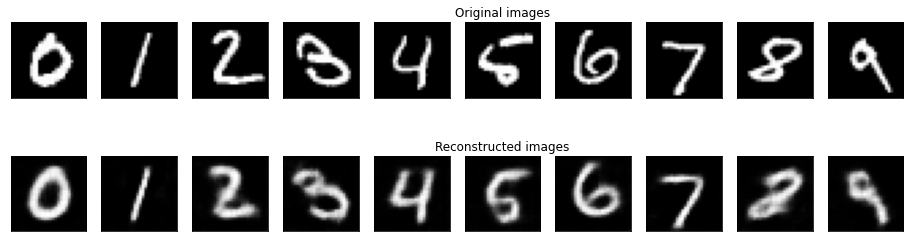

	 partial train loss (single batch): 0.026829
	 partial train loss (single batch): 0.025437
	 partial train loss (single batch): 0.026974
	 partial train loss (single batch): 0.027789
	 partial train loss (single batch): 0.025226
	 partial train loss (single batch): 0.027428
	 partial train loss (single batch): 0.025134
	 partial train loss (single batch): 0.026256
	 partial train loss (single batch): 0.025339
	 partial train loss (single batch): 0.026888
	 partial train loss (single batch): 0.027128
	 partial train loss (single batch): 0.026393
	 partial train loss (single batch): 0.025491
	 partial train loss (single batch): 0.026238
	 partial train loss (single batch): 0.026594
	 partial train loss (single batch): 0.026654
	 partial train loss (single batch): 0.025678
	 partial train loss (single batch): 0.026920
	 partial train loss (single batch): 0.026807
	 partial train loss (single batch): 0.025777
	 partial train loss (single batch): 0.024545
	 partial train loss (single batch

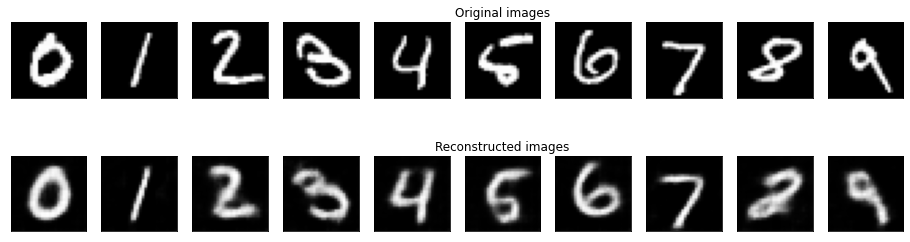

	 partial train loss (single batch): 0.026692
	 partial train loss (single batch): 0.025386
	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.027655
	 partial train loss (single batch): 0.025158
	 partial train loss (single batch): 0.027317
	 partial train loss (single batch): 0.025092
	 partial train loss (single batch): 0.026257
	 partial train loss (single batch): 0.025279
	 partial train loss (single batch): 0.026784
	 partial train loss (single batch): 0.027030
	 partial train loss (single batch): 0.026320
	 partial train loss (single batch): 0.025305
	 partial train loss (single batch): 0.026153
	 partial train loss (single batch): 0.026454
	 partial train loss (single batch): 0.026553
	 partial train loss (single batch): 0.025641
	 partial train loss (single batch): 0.026817
	 partial train loss (single batch): 0.026700
	 partial train loss (single batch): 0.025651
	 partial train loss (single batch): 0.024431
	 partial train loss (single batch

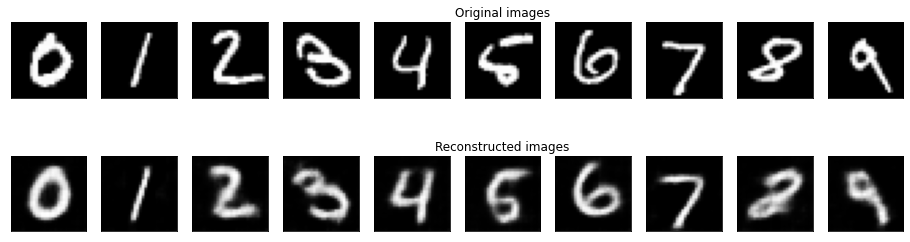

	 partial train loss (single batch): 0.026565
	 partial train loss (single batch): 0.025354
	 partial train loss (single batch): 0.026796
	 partial train loss (single batch): 0.027551
	 partial train loss (single batch): 0.025109
	 partial train loss (single batch): 0.027178
	 partial train loss (single batch): 0.025021
	 partial train loss (single batch): 0.026123
	 partial train loss (single batch): 0.025133
	 partial train loss (single batch): 0.026691
	 partial train loss (single batch): 0.026973
	 partial train loss (single batch): 0.026203
	 partial train loss (single batch): 0.025244
	 partial train loss (single batch): 0.026101
	 partial train loss (single batch): 0.026355
	 partial train loss (single batch): 0.026420
	 partial train loss (single batch): 0.025538
	 partial train loss (single batch): 0.026677
	 partial train loss (single batch): 0.026635
	 partial train loss (single batch): 0.025541
	 partial train loss (single batch): 0.024342
	 partial train loss (single batch

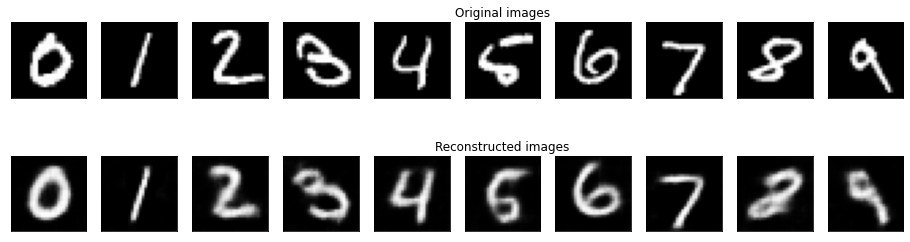

	 partial train loss (single batch): 0.026450
	 partial train loss (single batch): 0.025324
	 partial train loss (single batch): 0.026741
	 partial train loss (single batch): 0.027455
	 partial train loss (single batch): 0.025079
	 partial train loss (single batch): 0.027133
	 partial train loss (single batch): 0.024890
	 partial train loss (single batch): 0.026064
	 partial train loss (single batch): 0.025084
	 partial train loss (single batch): 0.026650
	 partial train loss (single batch): 0.026904
	 partial train loss (single batch): 0.026208
	 partial train loss (single batch): 0.025168
	 partial train loss (single batch): 0.025988
	 partial train loss (single batch): 0.026457
	 partial train loss (single batch): 0.026409
	 partial train loss (single batch): 0.025440
	 partial train loss (single batch): 0.026687
	 partial train loss (single batch): 0.026635
	 partial train loss (single batch): 0.025412
	 partial train loss (single batch): 0.024262
	 partial train loss (single batch

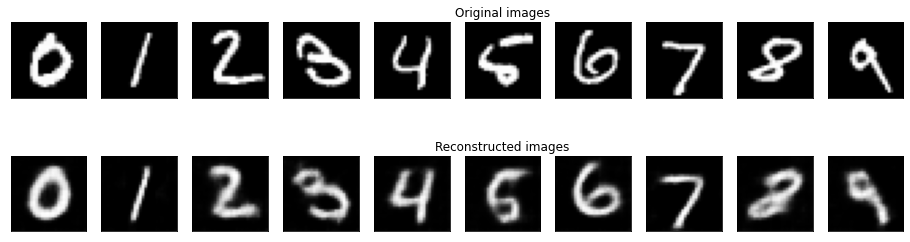

	 partial train loss (single batch): 0.026337
	 partial train loss (single batch): 0.025249
	 partial train loss (single batch): 0.026596
	 partial train loss (single batch): 0.027373
	 partial train loss (single batch): 0.025022
	 partial train loss (single batch): 0.027027
	 partial train loss (single batch): 0.024786
	 partial train loss (single batch): 0.026004
	 partial train loss (single batch): 0.025012
	 partial train loss (single batch): 0.026574
	 partial train loss (single batch): 0.026788
	 partial train loss (single batch): 0.026109
	 partial train loss (single batch): 0.025015
	 partial train loss (single batch): 0.025851
	 partial train loss (single batch): 0.026363
	 partial train loss (single batch): 0.026339
	 partial train loss (single batch): 0.025340
	 partial train loss (single batch): 0.026497
	 partial train loss (single batch): 0.026590
	 partial train loss (single batch): 0.025278
	 partial train loss (single batch): 0.024129
	 partial train loss (single batch

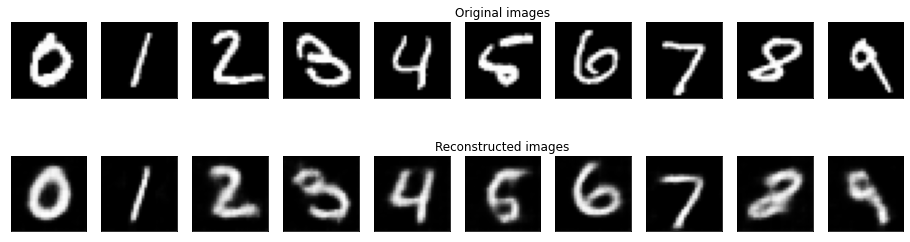

	 partial train loss (single batch): 0.026191
	 partial train loss (single batch): 0.025198
	 partial train loss (single batch): 0.026517
	 partial train loss (single batch): 0.027334
	 partial train loss (single batch): 0.024945
	 partial train loss (single batch): 0.026961
	 partial train loss (single batch): 0.024764
	 partial train loss (single batch): 0.025953
	 partial train loss (single batch): 0.024928
	 partial train loss (single batch): 0.026499
	 partial train loss (single batch): 0.026667
	 partial train loss (single batch): 0.026145
	 partial train loss (single batch): 0.024959
	 partial train loss (single batch): 0.025794
	 partial train loss (single batch): 0.026371
	 partial train loss (single batch): 0.026329
	 partial train loss (single batch): 0.025320
	 partial train loss (single batch): 0.026358
	 partial train loss (single batch): 0.026568
	 partial train loss (single batch): 0.025118
	 partial train loss (single batch): 0.024065
	 partial train loss (single batch

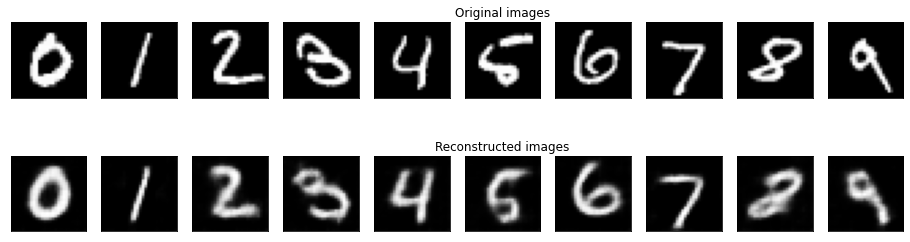

	 partial train loss (single batch): 0.026101
	 partial train loss (single batch): 0.025163
	 partial train loss (single batch): 0.026423
	 partial train loss (single batch): 0.027233
	 partial train loss (single batch): 0.025020
	 partial train loss (single batch): 0.026813
	 partial train loss (single batch): 0.024602
	 partial train loss (single batch): 0.025921
	 partial train loss (single batch): 0.024834
	 partial train loss (single batch): 0.026465
	 partial train loss (single batch): 0.026584
	 partial train loss (single batch): 0.026049
	 partial train loss (single batch): 0.024919
	 partial train loss (single batch): 0.025669
	 partial train loss (single batch): 0.026198
	 partial train loss (single batch): 0.026192
	 partial train loss (single batch): 0.025219
	 partial train loss (single batch): 0.026174
	 partial train loss (single batch): 0.026517
	 partial train loss (single batch): 0.025060
	 partial train loss (single batch): 0.023970
	 partial train loss (single batch

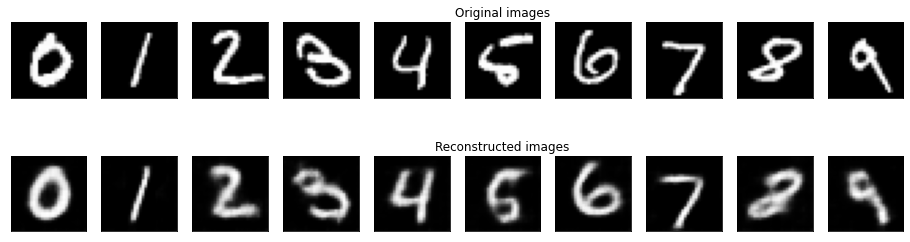

	 partial train loss (single batch): 0.025999
	 partial train loss (single batch): 0.025136
	 partial train loss (single batch): 0.026398
	 partial train loss (single batch): 0.027138
	 partial train loss (single batch): 0.024852
	 partial train loss (single batch): 0.026687
	 partial train loss (single batch): 0.024615
	 partial train loss (single batch): 0.025857
	 partial train loss (single batch): 0.024712
	 partial train loss (single batch): 0.026386
	 partial train loss (single batch): 0.026530
	 partial train loss (single batch): 0.026069
	 partial train loss (single batch): 0.024854
	 partial train loss (single batch): 0.025681
	 partial train loss (single batch): 0.026114
	 partial train loss (single batch): 0.026044
	 partial train loss (single batch): 0.025110
	 partial train loss (single batch): 0.026082
	 partial train loss (single batch): 0.026483
	 partial train loss (single batch): 0.024968
	 partial train loss (single batch): 0.023924
	 partial train loss (single batch

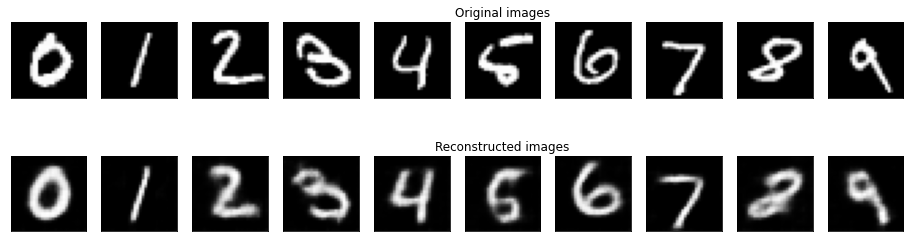

	 partial train loss (single batch): 0.025975
	 partial train loss (single batch): 0.025117
	 partial train loss (single batch): 0.026383
	 partial train loss (single batch): 0.027169
	 partial train loss (single batch): 0.024788
	 partial train loss (single batch): 0.026615
	 partial train loss (single batch): 0.024506
	 partial train loss (single batch): 0.025851
	 partial train loss (single batch): 0.024698
	 partial train loss (single batch): 0.026281
	 partial train loss (single batch): 0.026518
	 partial train loss (single batch): 0.025987
	 partial train loss (single batch): 0.024746
	 partial train loss (single batch): 0.025572
	 partial train loss (single batch): 0.025999
	 partial train loss (single batch): 0.026020
	 partial train loss (single batch): 0.025071
	 partial train loss (single batch): 0.026021
	 partial train loss (single batch): 0.026389
	 partial train loss (single batch): 0.024984
	 partial train loss (single batch): 0.023848
	 partial train loss (single batch

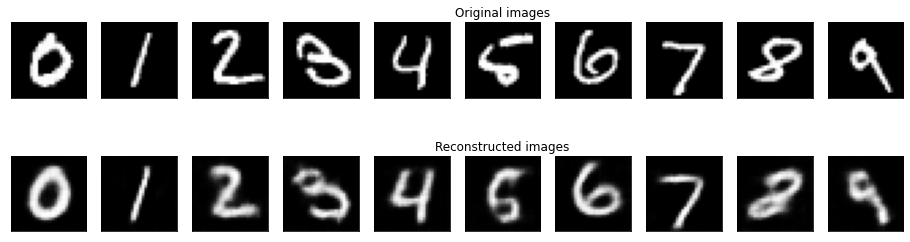

	 partial train loss (single batch): 0.025930
	 partial train loss (single batch): 0.025046
	 partial train loss (single batch): 0.026275
	 partial train loss (single batch): 0.027002
	 partial train loss (single batch): 0.024731
	 partial train loss (single batch): 0.026599
	 partial train loss (single batch): 0.024476
	 partial train loss (single batch): 0.025844
	 partial train loss (single batch): 0.024656
	 partial train loss (single batch): 0.026190
	 partial train loss (single batch): 0.026398
	 partial train loss (single batch): 0.025958
	 partial train loss (single batch): 0.024730
	 partial train loss (single batch): 0.025572
	 partial train loss (single batch): 0.025946
	 partial train loss (single batch): 0.025935
	 partial train loss (single batch): 0.025034
	 partial train loss (single batch): 0.025987
	 partial train loss (single batch): 0.026365
	 partial train loss (single batch): 0.024888
	 partial train loss (single batch): 0.023804
	 partial train loss (single batch

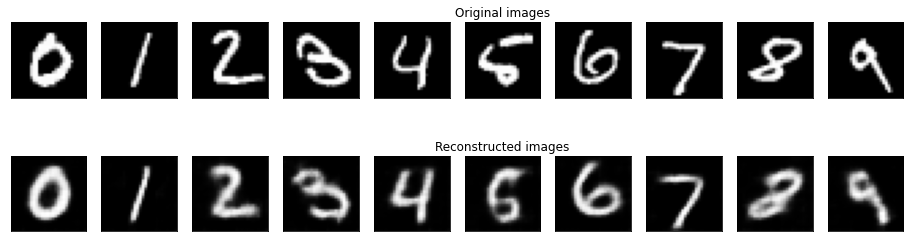

In [19]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [21]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.026115478947758675

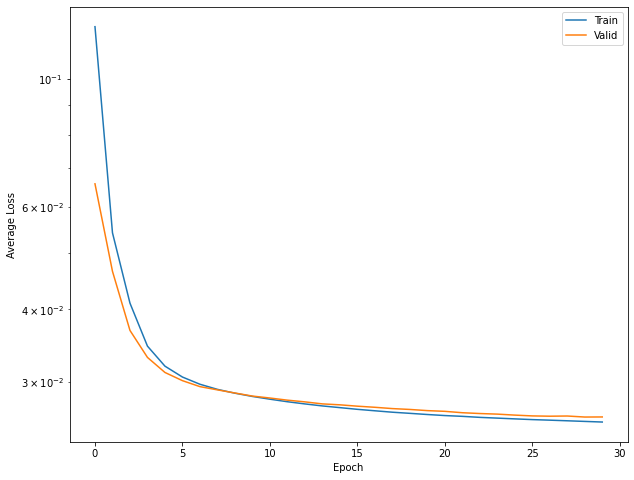

In [20]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# **5. Generate new samples from the random latent code**

tensor([-0.2514,  0.0896,  0.2369, -0.0712])
tensor([0.5308, 0.6400, 0.6483, 0.6384])


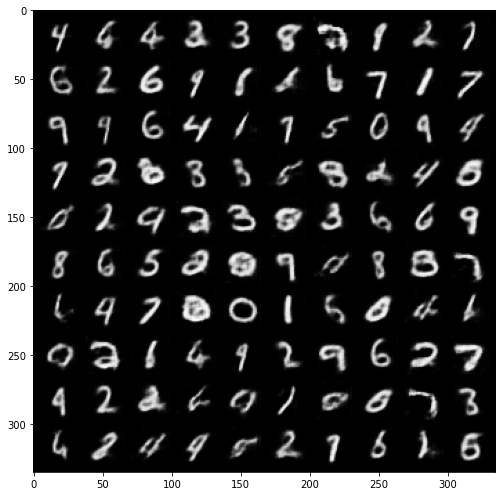

In [22]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

# **6. Visualize the latent space with t-SNE**

In [23]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from tqdm import tqdm
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:14<00:00, 684.24it/s]


Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -1.268704         0.583238         0.313384        -2.013883   
1            0.028200         0.160038         1.282632        -0.020051   
2           -1.148420         1.182258         0.562029         0.111616   
3            0.453222        -0.674205         0.200359         0.714921   
4            0.105490         0.246793        -0.974930        -0.042505   
...               ...              ...              ...              ...   
9995        -0.714926        -0.060262         1.342867        -0.645871   
9996         0.291398        -0.120881         0.914746         0.025421   
9997        -0.847653         0.600679        -0.947116        -0.009921   
9998        -0.797113        -0.736199         0.103146         0.312988   
9999         0.487403        -0.145802         0.373414         1.452491   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [25]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

